In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [105]:
actions = ["up", "down", "left", "right"]

class GridWorld():
    def __init__(self, rewardGrid, specStateGrid):
        #rewardGrid is a matrix of the rewards that can be obtained from each state
        self.grid = rewardGrid
        #stateGrid is a matrix indicating the start state, terminal state and obstacles
        self.stateGrid = specStateGrid
        self.numcols = len(rewardGrid[0])
        self.numrows = len(rewardGrid)
        
        self.livingReward = -1
        
    def getStartState(self):
        for i in range(self.numrows):
            for j in range(self.numcols):
                if self.stateGrid[i][j] == "S":
                    return (i, j)
    
    def getTerminalState(self):
        for i in range(self.numrows):
            for j in range(self.numcols):
                if self.stateGrid[i][j] == "T":
                    return (i, j)
    
    def isTerminal(self, state):
        if self.stateGrid[state[0]][state[1]] == 'T':
            return True
        return False   
    
    
    def getReward(self, state, action, nextState):
        return self.grid[state[0]][state[1]] + self.livingReward
    
    def getNextState(self, state, action):
        #if you try to go out of the grid or into an obstacle, will be forced to stay in the same state
        if action == "up":
            if state[0] - 1 < 0 or self.stateGrid[state[0] - 1][state[1]] == 'O':
                return state
            return (state[0] - 1, state[1])
        
        elif action == "down":
            if state[0] + 1 == self.numrows or self.stateGrid[state[0] + 1][state[1]] == 'O':
                return state
            return (state[0] + 1, state[1])
            
        elif action == "left":
            if state[1] - 1 < 0 or self.stateGrid[state[0]][state[1] - 1] == 'O':
                return state
            return (state[0], state[1] - 1)                                             
        
        elif action == "right":
            if state[1] + 1 == self.numcols or self.stateGrid[state[0]][state[1] + 1] == 'O':
                return state
            return (state[0], state[1] + 1)
                                                              
    
    def valueIteration(self, gamma = 1.0):
    
        vmatrix = np.zeros((self.numcols, self.numrows))
        
        while True:
            #if no state-values are updated in the current iteration, end loop
            isupdated = False

            for i in range(self.numrows):
                for j in range(self.numcols):
                    #if state is terminal, its value is just the reward you get in the state
                    if self.isTerminal((i,j)):
                        vmatrix[i][j] = self.grid[i][j] 
                        continue
                        
                    #if a particular cell of the grid is an obstacle, can't have a value
                    if self.stateGrid[i][j] == 'O':
                        vmatrix[i][j] = np.nan
                        continue
                    
                    vallist = []
                    
                    #explore all possible actions to find optimal value for state
                    for action in actions:
                        nstate = self.getNextState((i,j), action)
                        nreward = self.getReward((i,j), action, nstate)
                        vallist.append(nreward + gamma*vmatrix[nstate[0]][nstate[1]])
                    
                    newval = max(vallist)
                    
                    #set flag if a state value has been updated
                    if vmatrix[i][j] - newval > 0.01:
                        isupdated = True
                        
                    vmatrix[i][j] = newval
                    
            
            if not isupdated:
                break
        
        return vmatrix
    
    def optimalPolicy(self, vmatrix):
        polGrid = [[' ' for j in range(self.numcols)] for i in range(self.numrows)]
        
        for i in range(self.numrows):
            for j in range(self.numcols):
                if self.isTerminal((i,j)) or self.stateGrid[i][j] == 'O':
                    continue
                
                valarray = np.zeros(len(actions))
                k=0
                
                #find the value of taking each action from current state
                for action in actions:
                    nstate = self.getNextState((i,j), action)
                    nvalue = vmatrix[nstate[0]][nstate[1]]
                    valarray[k] = nvalue
                    k+=1
                
                #(indices of) actions that led to maximum value
                optchoices = np.where(valarray == valarray.max())[0]
                
                #append optimal actions to policy
                pol = []
                for choice in optchoices:
                    pol.append(actions[choice])
                    #pol += actions[choice]
                
                polGrid[i][j] = pol
        
        return polGrid

In [106]:
rewardGrid = np.zeros((5, 5))

rewardGrid[0][0] = 1
rewardGrid[0][1] = -1

stateGrid = [[' ' for j in range(5)] for i in range(5)]
stateGrid[0][0] = 'T'
stateGrid[1][1] = 'O'
stateGrid[2][1] = 'O'
stateGrid[1][2] = 'O'

gworld = GridWorld(rewardGrid, stateGrid)

val = gworld.valueIteration()
print(val)
print(gworld.optimalPolicy(val))

[[ 1. -1. -2. -3. -4.]
 [ 0. nan nan -4. -5.]
 [-1. nan -5. -5. -6.]
 [-2. -3. -4. -5. -6.]
 [-3. -4. -5. -6. -7.]]
[[' ', ['left'], ['left'], ['left'], ['left']], [['up'], ' ', ' ', ['up'], ['up', 'left']], [['up'], ' ', ['down'], ['up'], ['up', 'left']], [['up'], ['left'], ['left'], ['left'], ['left']], [['up'], ['up', 'left'], ['up', 'left'], ['up', 'left'], ['up', 'left']]]


In [107]:
class GridEnv():
    def __init__(self, size, potential = '0', gamma = 1.0):
        if size == "small":
            rewardGrid = np.zeros((5, 5))

            stateGrid = [[' ' for j in range(5)] for i in range(5)]
            stateGrid[0][4] = 'T'
            stateGrid[4][0] = 'S'
        
        else:
            rewardGrid = np.zeros((25, 25))

            stateGrid = [[' ' for j in range(25)] for i in range(25)]
            stateGrid[0][24] = 'T'
            stateGrid[24][0] = 'S'
        
        self.world = GridWorld(rewardGrid, stateGrid)
        self.state = self.world.getStartState()
        self.potential = potential
        self.terminal = self.world.getTerminalState()
        self.gamma = gamma
        
        #On taking an action, there is a 20% chance that the environment will take the agent in a random direction.
        self.noise = 0.2
    
    def getPseudoReward(self, state, action, nstate):
        if self.potential == '0':
            return 0
        
        currman = abs(state[0] - self.terminal[0]) + abs(state[1] - self.terminal[1])
        nextman = self.gamma*(abs(nstate[0] - self.terminal[0]) + abs(nstate[1] - self.terminal[1]))
               
        pseudoreward = (currman - nextman)/0.8
        
        if self.potential == 'halfmanhattan':
            return 0.5*pseudoreward
        
        return pseudoreward
            
    
    def interact(self, action):
        if self.world.isTerminal(self.state):
            return (True, self.state, self.world.grid[self.state[0]][self.state[1]])
        
        #whether the environment will take you in a random direction
        if np.random.uniform(0,1) <= self.noise:
            action = np.random.choice(actions)
        
        nstate = self.world.getNextState(self.state, action)
        nreward = self.world.getReward(self.state, action, nstate)
        pseudoreward = self.getPseudoReward(self.state, action, nstate)
        
        self.state = nstate
        return (False, nstate, nreward + pseudoreward)
    
    def reset(self):
        self.state = self.world.getStartState()
    
    def getState(self):
        return self.state

In [108]:
class Agent():
    
    def __init__(self, alpha = 0.5, epsilon = 0.05, gamma = 1.0, numEpisodes = 50, potential = '0', size = 'small'):
        self.alpha =  alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.numEpisodes = numEpisodes
        self.potential = potential
        self.size = size
        self.Q = {}
        
    def chooseAction(self):
        #if a state hasn't been encountered before, initialize it
        if not self.state in self.Q:
                self.Q[self.state] = {}
                for act in actions:
                    self.Q[self.state][act] = 0
        
        #picking a random action with probability epsilon
        if np.random.uniform(0,1) <= self.epsilon:
            return np.random.choice(actions)
        
        #lookup the Q values for each action from current state
        rewarray = np.zeros(len(actions))
        k=0
        for action in actions:
            rewarray[k] = self.Q[self.state][action]
            k+=1
 
        acts = []
        maxrew = max(rewarray)    
        for k in range(len(rewarray)):
            if rewarray[k] == maxrew:
                acts.append(actions[k])
        
        #if multiple actions have same Q-value, pick randomly
        return np.random.choice(acts)
    
    def runEpisode(self, env):
        self.state = env.getState()
        
        returns = 0
        steps = 1
        done = False
        while True:
            action = self.chooseAction()
            done, nstate, reward = env.interact(action)
            
            returns += reward
        
            if done:
                self.Q[self.state]["exit"] = reward
                break
            
            #if a state hasn't been encountered before, initialize it
            if not nstate in self.Q:
                self.Q[nstate] = {}
                for act in actions:
                    self.Q[nstate][act] = 0
            
            #find the maximum Q value from a particular state
            anext = max(self.Q[nstate], key=self.Q[nstate].get)
            qnext = self.Q[nstate][anext]
            
            #Update Q value estimate
            self.Q[self.state][action] = self.Q[self.state][action] + self.alpha*(reward + self.gamma*qnext - self.Q[self.state][action])
    
            self.state = nstate
            steps+=1
        
        return (returns, steps)
        
    def QLearning(self):
        env = GridEnv(self.size, self.potential, self.gamma)
        retlist = []
        steplist = []
        for i in range(self.numEpisodes):
            returns, steps = self.runEpisode(env)
            env.reset()
            retlist.append(returns)
            steplist.append(steps)
            
        return (retlist, steplist)
    

In [109]:
def plotAgent(size, numEpisodes = 100):
    retmatrix = []
    for i in range(20):    
        a = Agent(size = size, numEpisodes = numEpisodes, gamma = 1.0)
        retlist, _ = a.QLearning()
        retmatrix.append(retlist)
    
    retmatrix = np.array(retmatrix)
    retmatrix = retmatrix.T
    
    #compute average returns from the 20 agents
    ys = retmatrix.mean(axis = 1)
    #compute std. dev. of returns from  the 20 agents
    yerrs = retmatrix.std(axis = 1)
    
    #x-axis
    numeps = [i + 1 for i in range(len(ys))]
    
    plt.figure(figsize=(20,10))
    plt.errorbar(numeps, ys, yerr = yerrs)
    plt.xlabel("No. of episodes")
    plt.ylabel("Average reward")

In [110]:
#b = Agent(potential = 'halfmanhattan')
#print(b.QLearning())

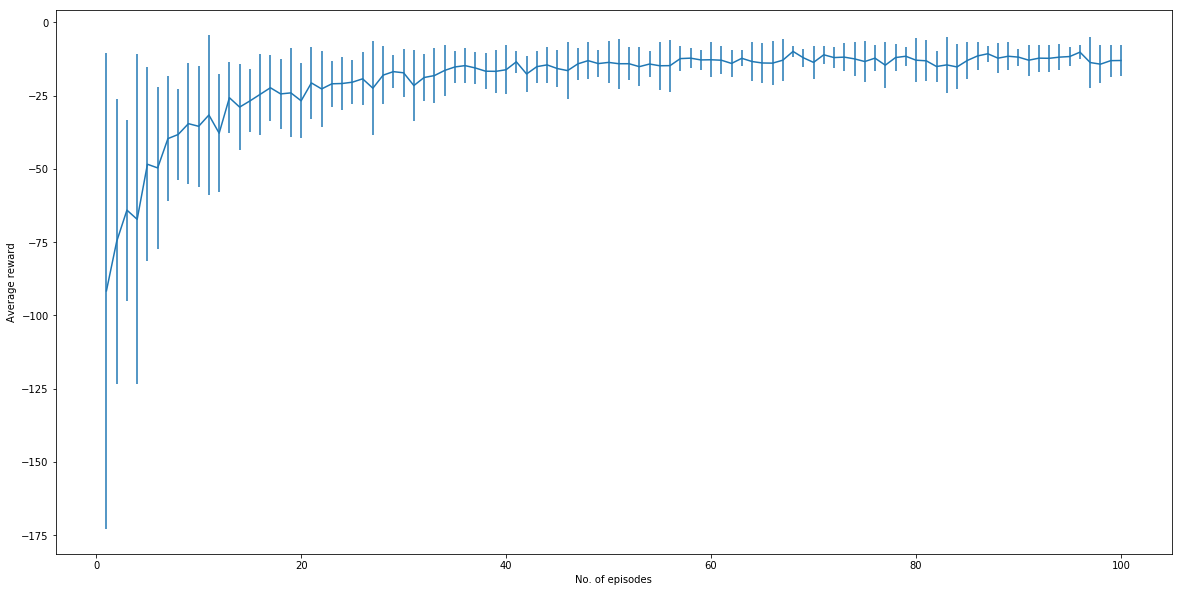

In [111]:
plotAgent(size = 'small')

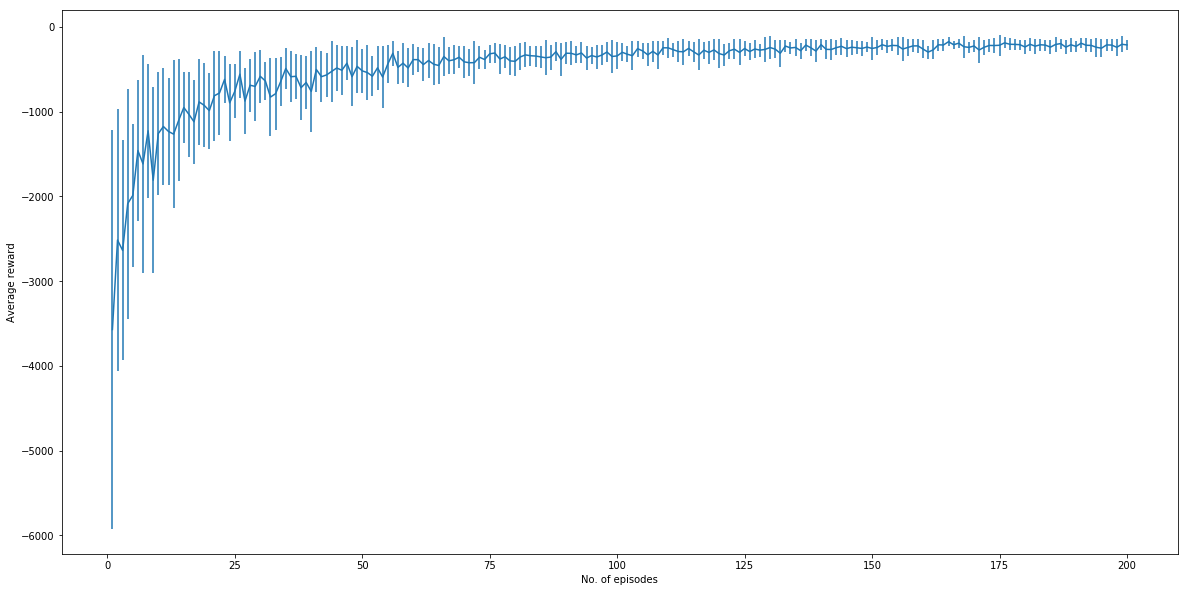

In [112]:
plotAgent(size = 'large', numEpisodes = 200)

In [113]:
def rewardShaping():
    #non -> no pseudo-reward
    #hman -> halfmanhattan pseudo-reward
    #man -> manhattan pseudo-reward
    stepsnon = []
    stepshman = []
    stepsman = []
    for i in range(20):
        anon = Agent(size = 'large', numEpisodes = 200, gamma = 1.0)
        _, stepnon = anon.QLearning()
        stepsnon.append(stepnon)
        
        ahman = Agent(size = 'large', numEpisodes = 200, gamma = 1.0, potential = 'halfmanhattan')
        _, stephman = ahman.QLearning()
        stepshman.append(stephman)
        
        aman = Agent(size = 'large', numEpisodes = 200, gamma = 1.0, potential = 'manhattan')
        _, stepman = aman.QLearning()
        stepsman.append(stepman)
        
    stepsnon = np.array(stepsnon)
    stepsnon = stepsnon.T
    ynon = stepsnon.mean(axis = 1)
    
    stepshman = np.array(stepshman)
    stepshman = stepshman.T
    yhman = stepshman.mean(axis = 1)
    
    stepsman = np.array(stepsman)
    stepsman = stepsman.T
    yman = stepsman.mean(axis = 1)
    
    numeps = [i + 1 for i in range(len(ynon))]
    
    plt.figure(figsize=(20,10))
    plt.plot(numeps, ynon, 'b', numeps, yhman, 'r', numeps, yman, 'y')
    plt.xlabel("No. of episodes")
    plt.ylabel("Average timesteps")
    plt.gca().legend(('no pseudo','approx pseudo','optimal pseudo'))

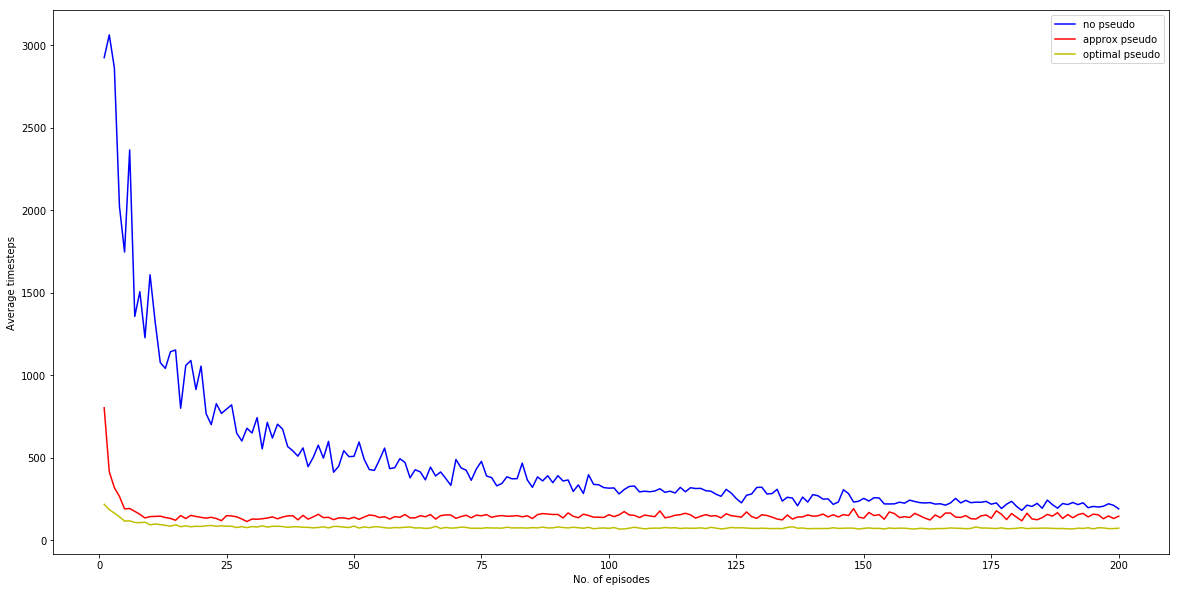

In [114]:
rewardShaping()